In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout,  Flatten
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, Xception, InceptionResNetV2, MobileNetV2
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = r'D:\AMIT\amit\DL\cat & dog\train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        if os.path.isfile(f_path):  
            filepaths.append(f_path)
    
            if fold == 'cats':
                labels.append('cat')
    
            elif fold == 'dogs':
                labels.append('dog')   

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

,filepaths,labels
0,D:\AMIT\amit\DL\cat & dog\train\cats\cat_1.jpg,cat
1,D:\AMIT\amit\DL\cat & dog\train\cats\cat_10.jpg,cat
2,D:\AMIT\amit\DL\cat & dog\train\cats\cat_100.jpg,cat
3,D:\AMIT\amit\DL\cat & dog\train\cats\cat_101.jpg,cat
4,D:\AMIT\amit\DL\cat & dog\train\cats\cat_102.jpg,cat
...,...,...
692,D:\AMIT\amit\DL\cat & dog\train\dogs\dog_92.jpg,dog
693,D:\AMIT\amit\DL\cat & dog\train\dogs\dog_93.jpg,dog
694,D:\AMIT\amit\DL\cat & dog\train\dogs\dog_97.jpg,dog
695,D:\AMIT\amit\DL\cat & dog\train\dogs\dog_98.jpg,dog


In [4]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [5]:
tr_gen = ImageDataGenerator(rescale= 1./255)
ts_gen = ImageDataGenerator(rescale= 1./255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= (224,224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= 16)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= (224,224), class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= 16)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= (224,224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= 16)

Found 557 validated image filenames belonging to 2 classes.


Found 70 validated image filenames belonging to 2 classes.
Found 70 validated image filenames belonging to 2 classes.


In [6]:
class_names = list(train_gen.class_indices.keys())
print("Class order:", class_names)

Class order: ['cat', 'dog']


In [7]:
base_model=Xception(include_top=False,weights="imagenet",input_shape=(224,224,3))
base_model.trainable=False

In [8]:
from tensorflow.keras.layers import BatchNormalization, Dropout

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    tf.keras.layers.Conv2D(3, (3,3), padding="same"),
    base_model,
    tf.keras.layers.Flatten(),
    BatchNormalization(),
    Dropout(0.2),
    tf.keras.layers.Dense(1028, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(2, activation='sigmoid')])
model.compile(optimizer=Adam(learning_rate= 0.0001),loss='binary_crossentropy', metrics= ['accuracy', AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 3)       84        
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 100352)           401408    
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1028)              103162884 
                                                        

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stop = EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            verbose=1,
            mode='max',
            restore_best_weights=True
            
        )
reduce_lr = ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.2,
            patience=3,
            min_lr=1e-30,
            verbose=1,
            mode='max'
        )
Checkpoint= ModelCheckpoint(
            'model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max')
callbacks = [early_stop, reduce_lr, Checkpoint]

In [10]:
history = model.fit(x= train_gen, epochs= 200, validation_data= test_gen, callbacks=callbacks)

Epoch 1/200
35/35 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.6786 - auc: 0.6638
Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to model.keras
35/35 [==============================] - 12s 193ms/step - loss: 0.7265 - accuracy: 0.6786 - auc: 0.6638 - val_loss: 0.5166 - val_accuracy: 0.8571 - val_auc: 0.9034 - lr: 1.0000e-04
Epoch 2/200
35/35 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.7163 - auc: 0.7470
Epoch 2: val_accuracy improved from 0.85714 to 0.88571, saving model to model.keras
35/35 [==============================] - 5s 153ms/step - loss: 0.6675 - accuracy: 0.7163 - auc: 0.7470 - val_loss: 0.4119 - val_accuracy: 0.8857 - val_auc: 0.9514 - lr: 1.0000e-04
Epoch 3/200
35/35 [==============================] - ETA: 0s - loss: 0.5500 - accuracy: 0.8169 - auc: 0.8249
Epoch 3: val_accuracy did not improve from 0.88571
35/35 [==============================] - 3s 95ms/step - loss: 0.5500 - accuracy: 0.8169 - auc: 0

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])


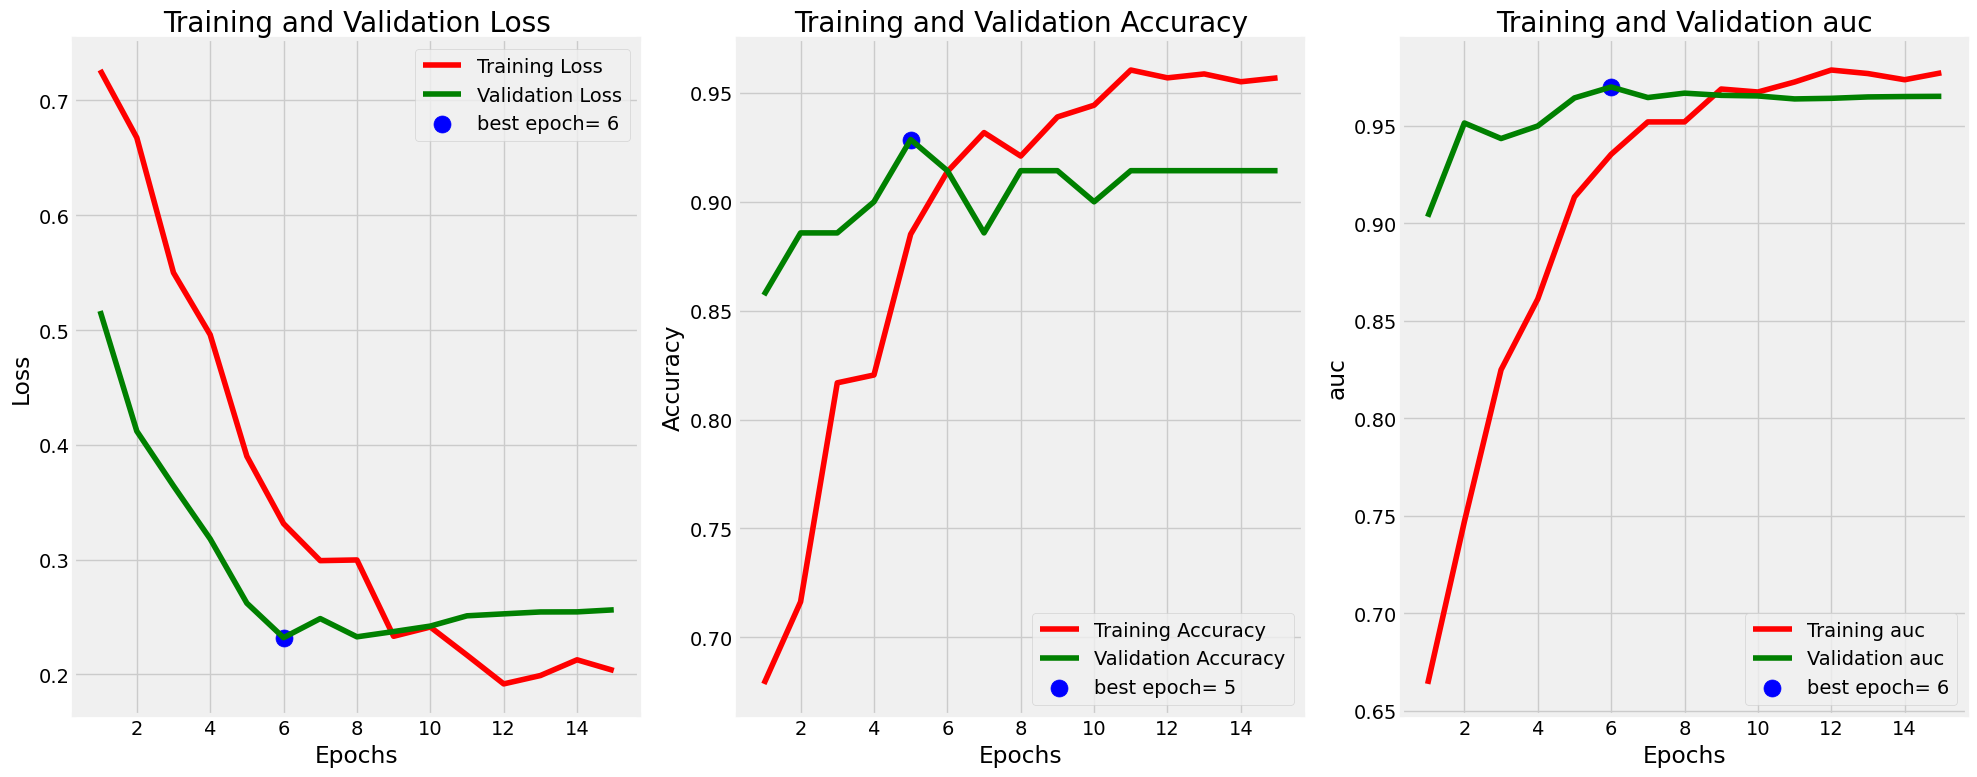

In [12]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_auc = history.history['auc']  
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_auc = history.history['val_auc'] 

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
index_auc = np.argmax(val_auc) 


acc_highest = val_acc[index_acc]
auc_highest = val_auc[index_auc] 


Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {index_loss + 1}'
acc_label = f'best epoch= {index_acc + 1}'
auc_label = f'best epoch= {index_auc + 1}'


plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(Epochs, tr_auc, 'r', label='Training auc')
plt.plot(Epochs, val_auc, 'g', label='Validation auc')
plt.scatter(index_auc + 1, auc_highest, s=150, c='blue', label=auc_label)
plt.title('Training and Validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()

plt.tight_layout()  
plt.show()

# **Evaluate model**

In [13]:
train_score = model.evaluate(train_gen )
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train AUC: ", train_score[2])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid AUC: ", valid_score[2])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test AUC: ", test_score[2])

5/5 [==============================] - 0s 54ms/step - loss: 0.2620 - accuracy: 0.9286 - auc: 0.9643
Train Loss:  0.14965300261974335
Train Accuracy:  0.9766606688499451
Train AUC:  0.9967478513717651
--------------------
Valid Loss:  0.22986987233161926
Valid Accuracy:  0.8999999761581421
Valid AUC:  0.9855102300643921
--------------------
Test Loss:  0.2620234191417694
Test Accuracy:  0.9285714030265808
Test AUC:  0.9642857313156128


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

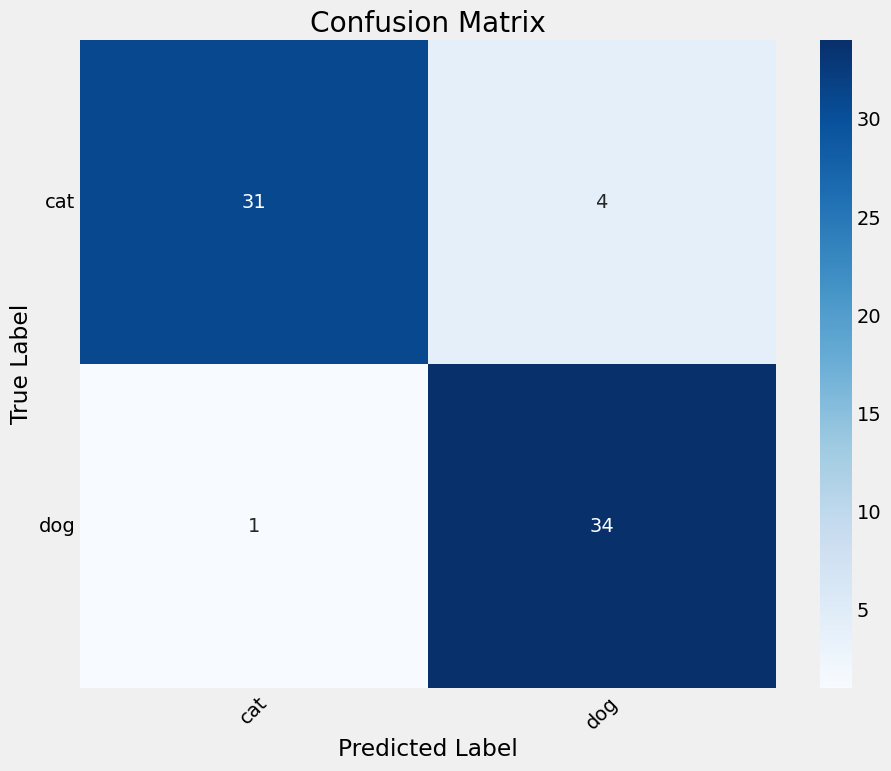

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d',  
    cmap="Blues",
    xticklabels=test_gen.class_indices.keys(),
    yticklabels=test_gen.class_indices.keys())

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [16]:
print(classification_report(test_gen.classes, y_pred, target_names= class_names))

              precision    recall  f1-score   support

         cat       0.97      0.89      0.93        35
         dog       0.89      0.97      0.93        35

    accuracy                           0.93        70
   macro avg       0.93      0.93      0.93        70
weighted avg       0.93      0.93      0.93        70

